In [2]:
#import file path
import os
from os import path
import glob

#data cleaning
import pandas as pd
import numpy as np
import datetime as dt
import re

#functional
import pickle
import time
import warnings
warnings.filterwarnings("ignore")

# STAT modeling
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

#import stock price
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# start =time.clock()
# end = time.clock()
# print('Running time: {} Seconds'.format(end-start))

## 1.1 Data Import

All the yellow taxi data downloaded from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page was kept in a folder named "Data". Under the "Data" folder every half a year data was kept in a subfolder. For instance, the data from January to June in 2012 was kept in the subfolder with the name "The data import and cleaning was done with half a year's data at a time, and then serialized into pickle file.

In [18]:
csv_path = 'Data/201201-06/'
csv_files = glob.glob(os.path.expanduser(os.path.join(csv_path, '*.csv')))
dfs = [pd.read_csv(f) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

## 1.2 Data Cleaning
Starting from the year 2015, the imported data has some minor changes in format (i.e., column names...), so the data cleaning was adjusted correspondingly.

### 1.2.1 Remove outliers

In [19]:
#remove the space at the beginning of each column name
df.columns = df.columns.str.lstrip()

In [20]:
if 'tpep_pickup_datetime' in df.columns:
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], infer_datetime_format=True)
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], infer_datetime_format=True)
    #Additional: Drop payment methods other than credit-card (method 1)
    df = df.loc[df['payment_type'] == 1, :]
else:
    df['tpep_pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], infer_datetime_format=True)
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], infer_datetime_format=True)
    #Additional: Drop payment methods other than credit-card (method 1)
    df = df.loc[df['payment_type'] == 'CRD', :]
    
#(1) Keep the period of 9:00 pm – 4:00 am (the next day).
df.drop(df[(df['tpep_pickup_datetime'].dt.hour < 21) & (df['tpep_pickup_datetime'].dt.hour > 3)].index, inplace=True)

#(2) When drop-off time precedes the pick-up time, swap pick-up, and drop-off times.
df['tpep_pickup_datetime'], df['tpep_dropoff_datetime'] = np.where(df['tpep_dropoff_datetime'] < df['tpep_pickup_datetime'], [df['tpep_dropoff_datetime'], df['tpep_pickup_datetime']], [df['tpep_pickup_datetime'], df['tpep_dropoff_datetime']])

#(3) Remove rides with duration equal to zero or longer than 3 hours.
df['duration'] =  df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
min_dur = dt.timedelta(seconds = 0)
max_dur = dt.timedelta(hours = 3)
df.drop(df[(df['duration'] > max_dur) | (df['duration'] == min_dur)].index, inplace=True)

#(4) Remove rides associated with a total payment lower than the minimum fare ($2.5 entry fee) or over $1000.
df.drop(df[(df['total_amount'] < 2.5) | (df['total_amount'] > 1000)].index, inplace=True)

#(5) Keep rides with at least one passenger and no more than five passengers.
df.drop(df[(df['passenger_count'] < 1) | (df['passenger_count'] > 5)].index, inplace=True)

#(6) Keep rides whose trip distance is at least 0.1 miles and less than 25 miles.
df.drop(df[(df['trip_distance'] < 0.1) | (df['trip_distance'] >= 25)].index, inplace=True)

#(7) Drop duplicates of identical pick-up time and pick-up latitude and pick-up longitude.
df.drop_duplicates(subset = ['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude'], inplace =True)      

#(8) Drop rides whose latitude and longitude are not between -90 and 90.
df.drop(df[(df['pickup_longitude'] < -90) | (df['pickup_longitude'] > 90)].index, inplace=True)
df.drop(df[(df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90)].index, inplace=True)
df.drop(df[(df['dropoff_longitude'] < -90) | (df['dropoff_longitude'] > 90)].index, inplace=True)
df.drop(df[(df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90)].index, inplace=True)

### 1.2.2 import Job-posting and IB data

In [3]:
job = pd.read_csv('Job postings data.csv')
ib = pd.read_csv('Investment bank locations.csv')
#convert month to datetime object
job['month'] =  pd.to_datetime(job['month'], format = '%y-%b').dt.to_period('M')

ib.dropna(inplace= True)
ib.reset_index(drop=True, inplace=True)
ib['LON'] = ib['LON'].astype(float)
#Federal Reserve Bank of New York Building is removed for there is no job-posting information on it
ib.drop(ib[ib['BANK'] == 'Federal Reserve Bank of New York Building'].index, inplace = True)
# make the bank names consistent across the two csv sources
ib['BANK'] = ib['BANK'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x))
ib['BANK'] = ib['BANK'].str.strip()
ib['BANK'] = ib['BANK'].str.lower()
ib['BANK'] = ib['BANK'].replace(' ', '.', regex=True)
ib['BANK'] = ib['BANK'].replace('ubsinc', 'ubs', regex=True)
job['company'] = job['company'].str.lower()
job['company'] = job['company'].replace('the.bank.of.new.york.mellon', 'bny.mellon', regex=True)
#reset the index for 'job' to match other series
job = job.set_index(['month', 'company'])

In [22]:
#keep the bank index for mapping afterwards
ib_dict = ib.loc[:,'BANK'].to_dict()

In [23]:
#set the datestamp to be 1 June, 2014 (when BNY Mellon moved its office)
ds = pd.to_datetime('2014/06/01')
 
#used for data after June 2014
if df.loc[df.index[0],'tpep_pickup_datetime'] >= ds:
    ib = ib.drop(index = 2)
else:
    #used for data before June 2014
    ib = ib.drop(index = 15)     

### 1.2.3 Add new variables

In [24]:
#To add pick-up bank
column_names = []
for i in ib.index:
    column_names.append(str(i))
    
for i in range(len(ib)):   
    df[column_names[i]] = np.sum(np.square(df.loc[:,['pickup_longitude', 'pickup_latitude']].values - ib.loc[int(column_names[i]), ['LON', 'LAT']].values),axis = 1).astype('float64')
df['pickup_bank_index'] = df[column_names].idxmin(axis=1).astype('int')
df['pickup_bank_distance'] = df[column_names].min(axis=1)
#use integer 99 to represent not within 0.06 miles of any bank
df['pickup_bank_index'] = np.where(df['pickup_bank_distance'] < 0.06**2, df['pickup_bank_index'], 99)

#To add drop-off bank
for i in range(len(ib)):   
    df[column_names[i]] = np.sum(np.square(df.loc[:,['dropoff_longitude', 'dropoff_latitude']].values - ib.loc[int(column_names[i]), ['LON', 'LAT']].values),axis = 1).astype('float64')
df['dropoff_bank_index'] = df[column_names].idxmin(axis=1).astype('int')
df['dropoff_bank_distance'] = df[column_names].min(axis=1)
#use integer 99 to represent not within 0.06 miles of any bank
df['dropoff_bank_index'] = np.where(df['dropoff_bank_distance'] < 0.06**2, df['dropoff_bank_index'], 99)

#drop the data with banks as neither pickup nor dropoff positions
df.drop(df[(df['pickup_bank_index'] == 99) & (df['dropoff_bank_index'] == 99)].index, inplace=True)

#map the bank names to each pickup & dropoff
df['pickup_bank'] = df['pickup_bank_index'].replace(ib_dict)
df['dropoff_bank'] = df['dropoff_bank_index'].replace(ib_dict)

df['tip_ratio'] = df['tip_amount'] / df['total_amount']
df['month'] = df['tpep_pickup_datetime'].dt.to_period('M')

new_df = df[['month','tip_ratio', 'pickup_bank_index', 'dropoff_bank_index', 'pickup_bank', 'dropoff_bank']].copy()

### 1.2.4 Serialize to pickle file

In [25]:
with open('201201-06.pickle', 'wb') as pickle_out:
    pickle.dump(new_df, pickle_out)

### 1.3.1 Additional data - import stock price from Yahoo!Finance

In [41]:
def getMonthPrice(tickerCode):
    '''
    This function is used to get adjusted-close price from yahoo!finance
    input: the stock ticker in string
    output: a pandas series with year-month as index and 'adjusted close price' as value
    '''
    #Set starting and ending datetimes for the dataset
    start = dt.datetime(2011, 12, 1) #starting from the end of 2011 so that we can calculate the monthly return in Jan 2012
    end = dt.datetime(2016, 6, 30)
    #get the adjusted-closing price
    df = pdr.get_data_yahoo(tickerCode, start, end).loc[start:end, 'Adj Close'].to_frame()
    #calculate average price within a month
    df = df.reset_index()
    df['month'] = df['Date'].dt.to_period('M')
    df.drop(columns = ['Date'], inplace = True)
    df = df.groupby('month').mean()
    return df

In [42]:
company_names = ['bank.of.america', 'barclays', 'bny.mellon', 'citigroup','credit.suisse', 'deutsche.bank', 
                 'goldman.sachs', 'jpmorgan.chase', 'morgan.stanley', 'rbc.capital.markets', 'ubs']
tickers = ['BAC','BCS','BK','C', 'CS', 'DB', 'GS', 'JPM', 'MS', 'RY', 'UBS']
stocks = [getMonthPrice(ticker) for ticker in tickers]
stocks = pd.concat(stocks, axis = 1)
stocks.columns = company_names

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [43]:
#The stock price for UBS on Yahoo!Finance cannot cover data before Dec 2014, so additional data was downloaded from Internet
ubs = pd.read_csv('UBSG_historical_price.csv')
ubs['month'] =  pd.to_datetime(ubs['日期'], format = '%Y年%m月%d日').dt.to_period('M')
ubs_price = ubs.groupby('month').收盘.mean()
stocks['ubs'] = np.where(stocks['ubs'].isnull(), ubs_price, stocks['ubs'] )

In [6]:
stock_return = np.log(stocks / stocks.shift(1))
stock_return.dropna(inplace = True)

In [7]:
stock_return.reset_index(inplace = True)
stock_return = pd.melt(stock_return, id_vars = ['month'], var_name = 'company', value_name = 'stock_return')
stock_return.set_index(['month', 'company'], inplace = True)
stock_return.head()

,,stock_return
month,company,
2012-01,bank.of.america,0.214105
2012-02,bank.of.america,0.162144
2012-03,bank.of.america,0.121862
2012-04,bank.of.america,-0.026216
2012-05,bank.of.america,-0.159325


### 1.3.2 Combine the data on hand

In [9]:
#Import pickled files
pickle_path = '/Users/jingyunliu/Desktop/RA_Test/pickled_data/'
pickle_files = glob.glob(os.path.expanduser(os.path.join(pickle_path, '*.pickle')))
dfs = [pickle.load(open(pickle_file,"rb")) for pickle_file in pickle_files]
df = pd.concat(dfs, ignore_index=True)

#store the data related to drop-off banks in 'dropoff'
dropoff = df.loc[:,['month', 'tip_ratio', 'dropoff_bank']]
#concentrate on pick-up banks for now 
pick = df.loc[:,['month', 'tip_ratio', 'pickup_bank']]
#remove the entries without pick-up from banks
pick.drop(pick[pick['pickup_bank'] == 99].index, inplace = True)
#change the column name to match the column name in job dataframe
pick = pick.rename(columns = {'pickup_bank': 'company'})

#get the average tip ratio per month for each bank
tip_ratio = pick.groupby(['month', 'company']).tip_ratio.mean()
#get the total number of taxi pick-ups per month for each bank
pickup_count = pick.groupby(['month', 'company']).tip_ratio.count()

#construct the dataframe used for regression analysis
df = pd.concat([tip_ratio, pickup_count, stock_return, job], axis = 1, join='outer')
df.columns = ['tip_ratio', 'pickup_count','stock_return', 'job_post']
#fill the nan with 0 for we assume 0 job was posted
df['job_post']= df['job_post'].fillna(0)

In [11]:
# df.describe().to_csv('describe.csv')

## 1.4 Preprocessing - Data Standardization
Due to the large differernce among the range of variables, the predictors are standardized. The interaction term is calculated after standardization to avoid being dominated by any of the terms.

In [11]:
norm = pd.DataFrame(preprocessing.scale(df), columns = df.columns, index = df.index )
norm.reset_index(inplace = True)
#the interaction term between tip ratio & pick-up count
norm['tip_times_pickup'] = norm['tip_ratio'] * norm['pickup_count']
norm.describe()

,tip_ratio,pickup_count,stock_return,job_post,tip_times_pickup
count,5.940000e+02,5.940000e+02,5.940000e+02,5.940000e+02,594.000000
mean,-3.450663e-15,-6.149215e-17,-2.186803e-17,5.980999e-18,-0.120194
std,1.000843e+00,1.000843e+00,1.000843e+00,1.000843e+00,0.867615
min,-3.510029e+00,-8.599587e-01,-4.482905e+00,-7.522013e-01,-2.985508
25%,-6.565972e-01,-7.845566e-01,-5.351225e-01,-6.310915e-01,-0.522230
50%,-4.184556e-02,-3.726660e-01,1.300537e-01,-3.939182e-01,-0.045987
75%,6.064037e-01,4.604446e-01,5.678806e-01,2.023792e-01,0.167105
max,3.831191e+00,3.062623e+00,3.406060e+00,5.643067e+00,3.011065


## 1.5 Exploratory Data Analysis

### 1.5.1 Stock Return

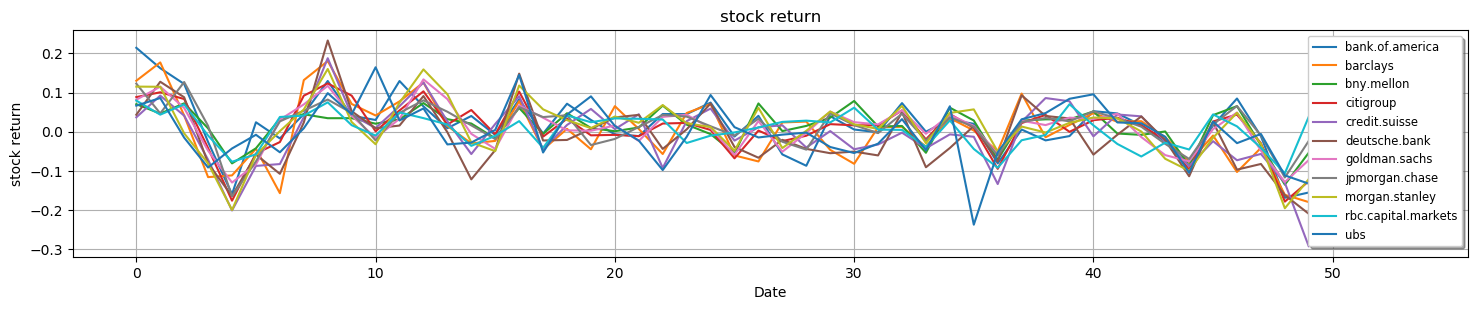

In [7]:
stock_plot = stock_return.unstack()
stock_plot.columns = stock_plot.columns.droplevel()

plt.figure(figsize=(18,3),dpi=100)
for i in stock_plot.columns:
    plt.plot(stock_plot[i].values, label = i )
plt.title('stock return')
plt.xlabel('Date')
plt.ylabel('stock return')
plt.legend(loc = 'best', shadow = True, fontsize = 'small') 
plt.grid()
plt.show()

### 1.5.2 Distribution of Predictors

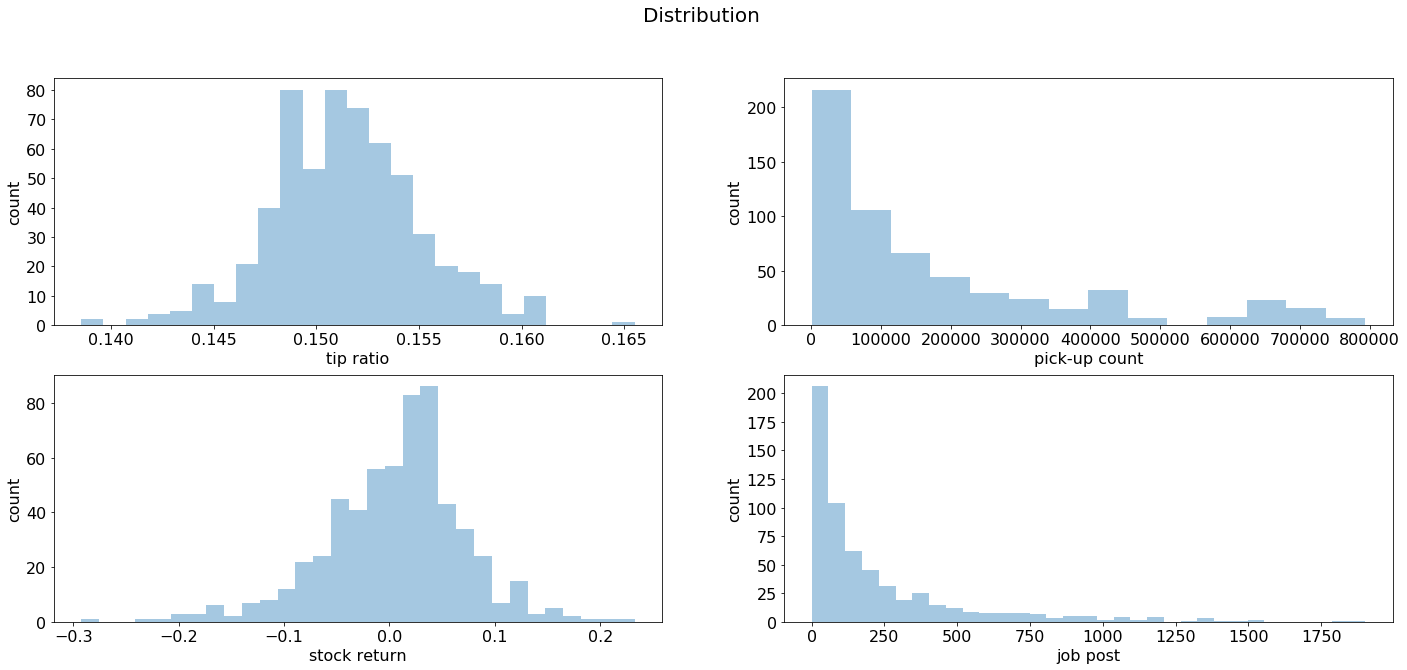

In [9]:
#plot the distribution of each variable
fig = plt.figure(figsize=(24,10))
fig.suptitle('Distribution',fontsize=20)
plt.subplot(2,2,1)
sns.distplot(df['tip_ratio'], kde = False)
plt.xlabel('tip ratio',fontsize=16)
plt.ylabel('count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2,2,2)
sns.distplot(df['pickup_count'], kde = False)
plt.xlabel('pick-up count',fontsize=16)
plt.ylabel('count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2,2,3)
sns.distplot(df['stock_return'], kde = False)
plt.xlabel('stock return',fontsize=16)
plt.ylabel('count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2,2,4)
sns.distplot(df['job_post'], kde = False)
plt.xlabel('job post',fontsize=16)
plt.ylabel('count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('pickup_distribution.png')
plt.show()

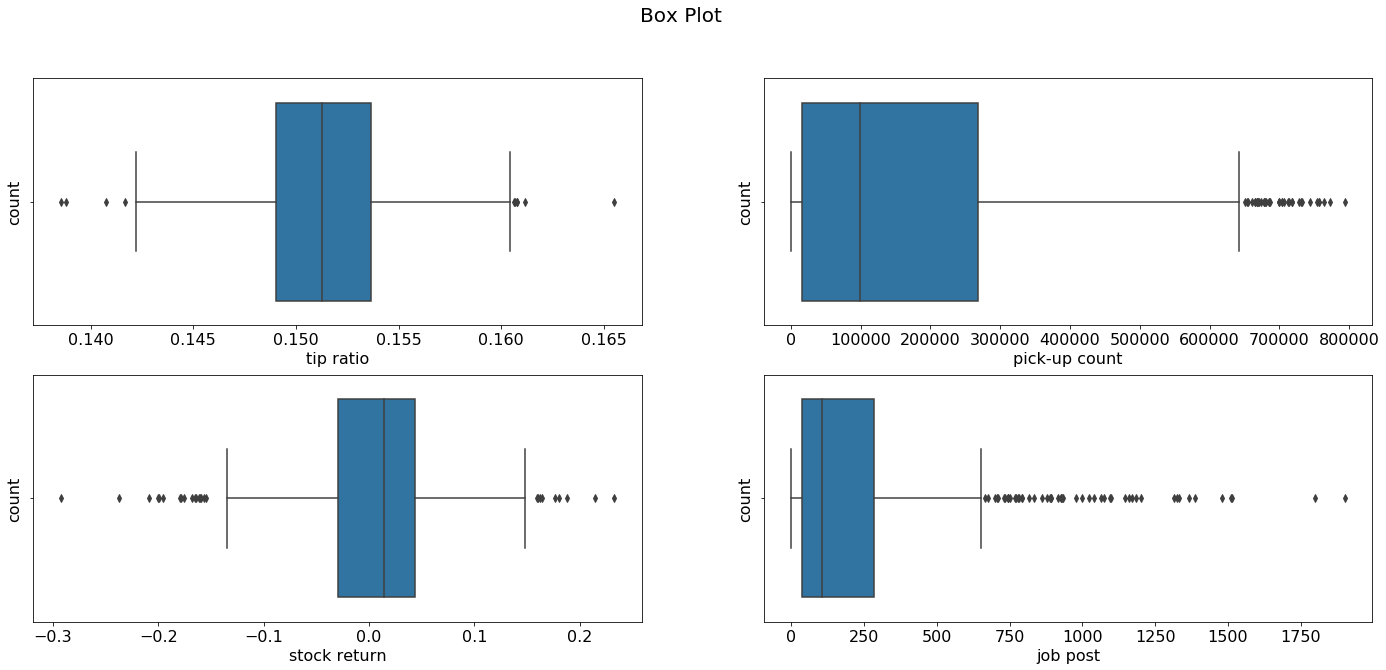

In [10]:
#plot the box plot of each variable
fig = plt.figure(figsize=(24,10))
fig.suptitle('Box Plot',fontsize=20)
plt.subplot(2,2,1)
sns.boxplot(df['tip_ratio'])
plt.xlabel('tip ratio',fontsize=16)
plt.ylabel('count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2,2,2)
sns.boxplot(df['pickup_count'])
plt.xlabel('pick-up count',fontsize=16)
plt.ylabel('count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2,2,3)
sns.boxplot(df['stock_return'])
plt.xlabel('stock return',fontsize=16)
plt.ylabel('count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2,2,4)
sns.boxplot(df['job_post'])
plt.xlabel('job post',fontsize=16)
plt.ylabel('count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('pickup_boxPlot.png')
plt.show()

### 1.5.3 Scatter Matrix between each pair of variables

In [14]:
# to add year fixed effect
norm['year'] = norm['month'].apply(lambda x : x.year)

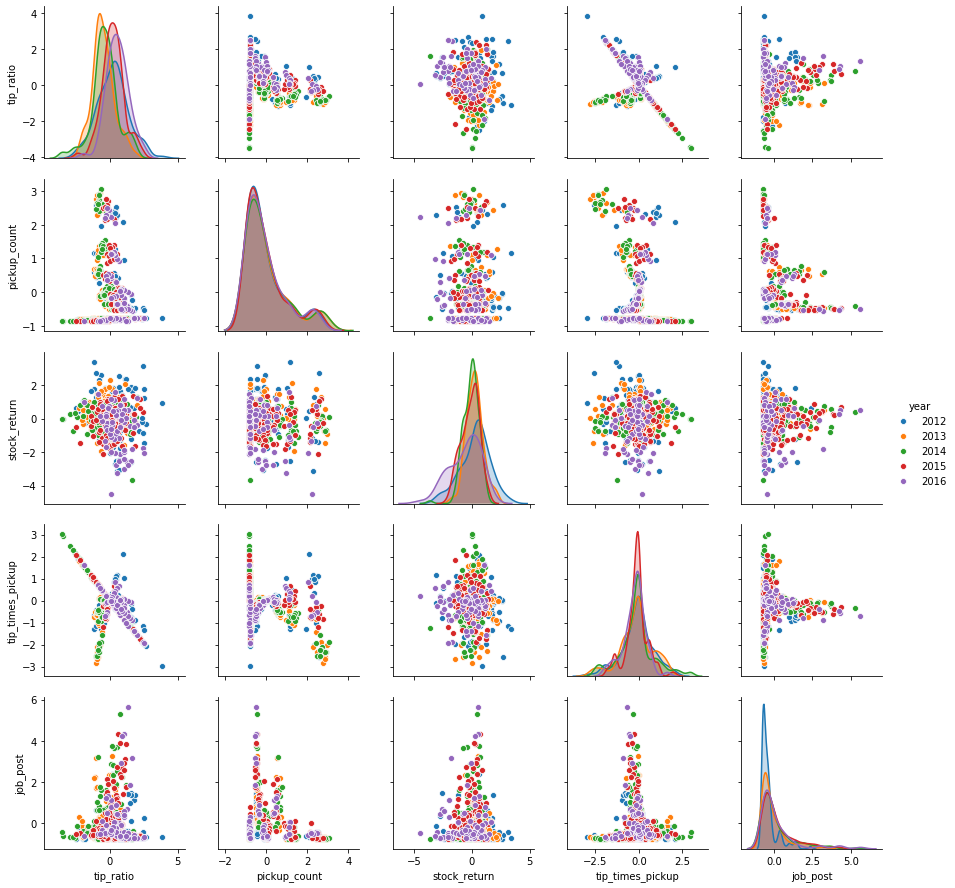

In [15]:
#with year as hue 
sns.pairplot(norm.iloc[:, 2:], vars = norm.iloc[:, np.r_[2:5, 6, 5]], hue='year')
plt.savefig('scatterMatrix_yearFixed.png')
plt.show()

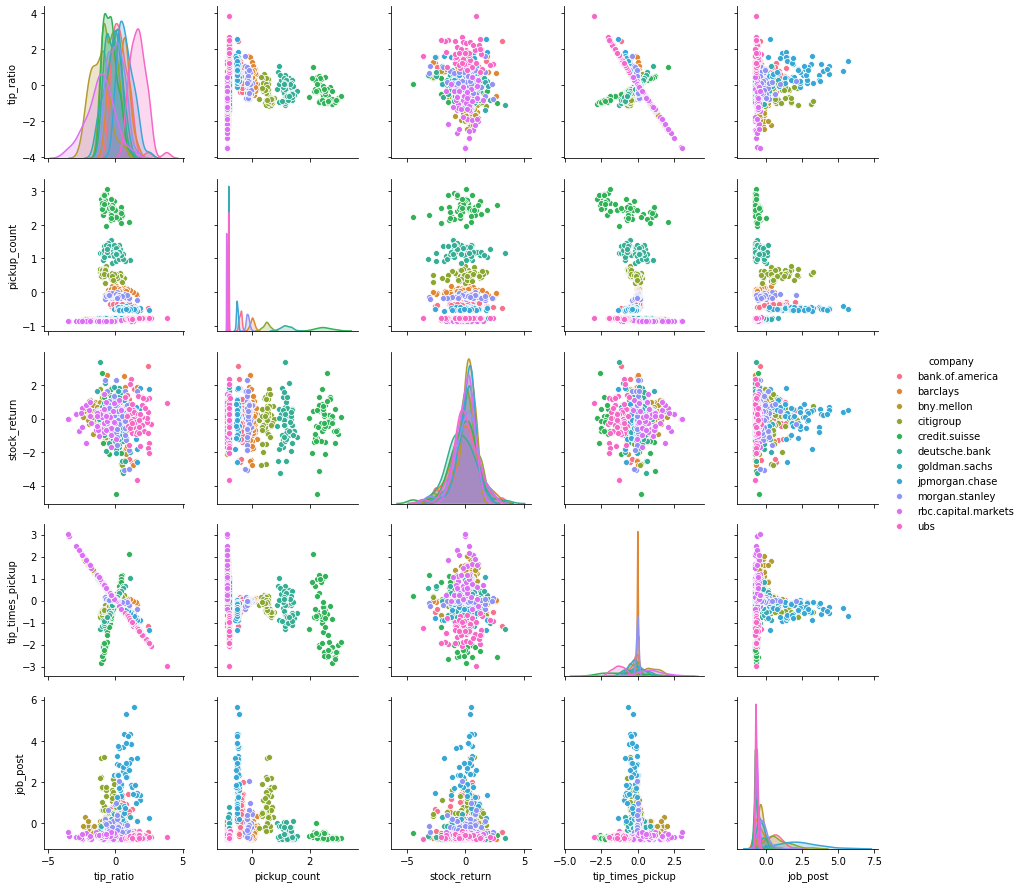

In [16]:
#with firm as hue
sns.pairplot(norm.iloc[:, np.r_[1:5, 6, 5]], hue='company')
plt.savefig('scatterMatrix_firmFixed.png')
plt.show()

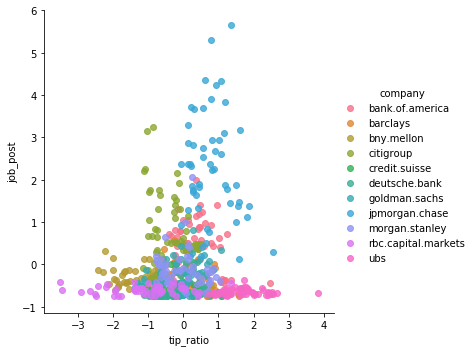

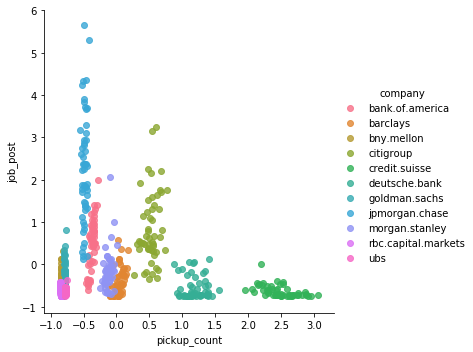

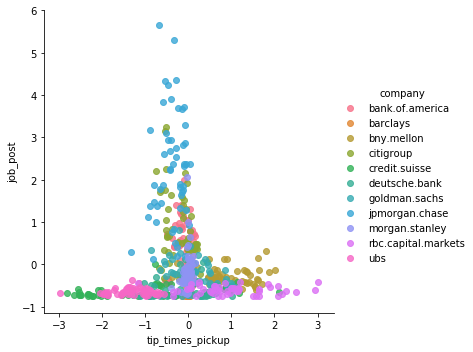

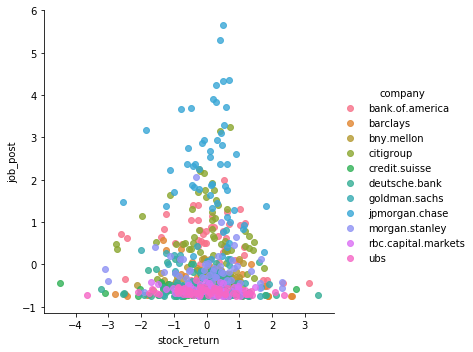

In [17]:
#generate individual scatter plot for each predictor against the response variable 
sns.lmplot('tip_ratio', 'job_post', data = norm, hue='company', fit_reg=False)
plt.savefig('tip_ratio_scatter.png')
plt.show()

sns.lmplot('pickup_count', 'job_post', data = norm, hue='company', fit_reg=False)
plt.savefig('pickup_count_scatter.png')
plt.show()

sns.lmplot('tip_times_pickup', 'job_post', data = norm, hue='company', fit_reg=False)
plt.savefig('tip_times_pickup_scatter.png')
plt.show()

sns.lmplot('stock_return', 'job_post', data = norm, hue='company', fit_reg=False)
plt.savefig('stock_return_scatter.png')
plt.show()

### 1.5.4  Drop-off Bank

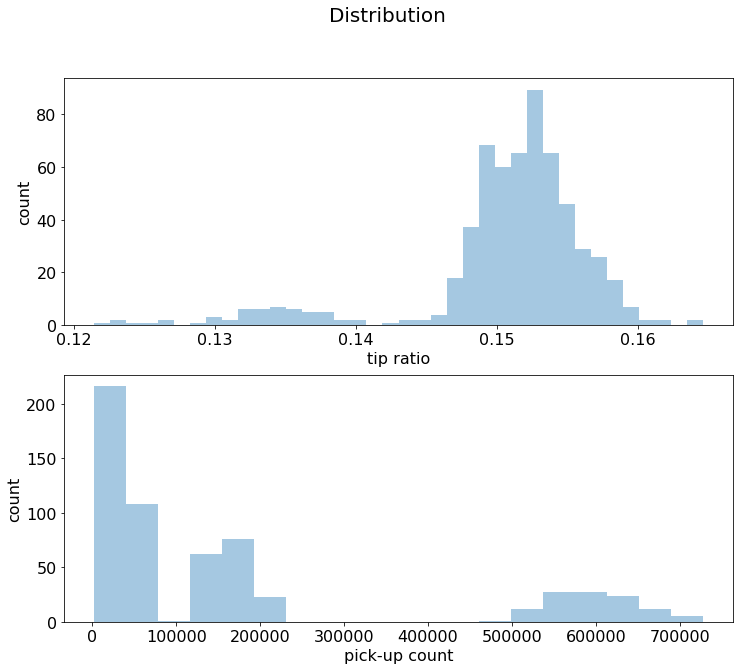

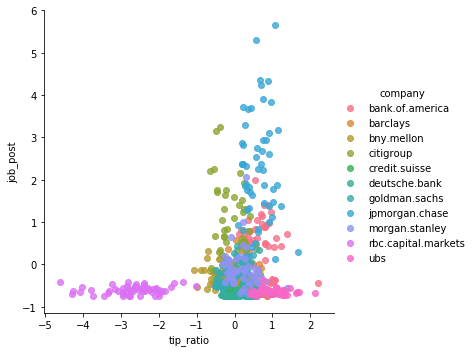

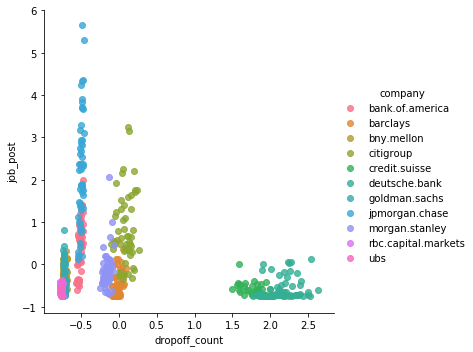

In [83]:
#remove the entries without pick-up from banks
dropoff.drop(dropoff[dropoff['dropoff_bank'] == 99].index, inplace = True)
#change the column name to match the column name in job dataframe
dropoff = dropoff.rename(columns = {'dropoff_bank': 'company'})
#get the average tip ratio per month for each bank
tip_ratio = dropoff.groupby(['month', 'company']).tip_ratio.mean()
#get the total number of taxi pick-ups per month for each bank
dropoff_count = dropoff.groupby(['month', 'company']).tip_ratio.count()

df_drop = pd.concat([tip_ratio, dropoff_count, stock_return, job], axis = 1, join='outer')
df_drop.columns = ['tip_ratio', 'dropoff_count','stock_return', 'job_post']
#fill the nan with 0 for we assume 0 job was posted
df_drop['job_post']= df_drop['job_post'].fillna(0)

fig = plt.figure(figsize=(12,10))
fig.suptitle('Distribution',fontsize=20)
plt.subplot(2,1,1)
sns.distplot(df_drop['tip_ratio'], kde = False)
plt.xlabel('tip ratio',fontsize=16)
plt.ylabel('count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2,1,2)
sns.distplot(df_drop['dropoff_count'], kde = False)
plt.xlabel('pick-up count',fontsize=16)
plt.ylabel('count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('dropoff_distribution.png')
plt.show()

#Standardize the data
df_drop_norm = pd.DataFrame(preprocessing.scale(df_drop), columns = df_drop.columns, index = df_drop.index )
df_drop_norm.reset_index(inplace = True)
#the interaction term between tip ratio & pick-up count
df_drop_norm['tip_times_dropoff'] = df_drop_norm['tip_ratio'] * df_drop_norm['dropoff_count']

#plot the scatter-plot between the new predico
sns.lmplot('tip_ratio', 'job_post', data = df_drop_norm, hue='company', fit_reg=False)
# plt.savefig('dropoff_tip_ratio_scatter.png')
plt.show()

sns.lmplot('dropoff_count', 'job_post', data = df_drop_norm, hue='company', fit_reg=False)
# plt.savefig('dropoff_count_scatter.png')
plt.show()

# 2. Regression

## 2.1 Multicollinearity Test

## 2.1.1 Pearson Correlation

In [18]:
X, y = norm.loc[:, ['tip_ratio', 'pickup_count', 'tip_times_pickup', 'stock_return']], norm.loc[:, 'job_post']
pearsoncorr = X.corr(method='pearson')
# pearsoncorr.to_csv('pearsoncorr.csv')
pearsoncorr

,tip_ratio,pickup_count,tip_times_pickup,stock_return
tip_ratio,1.000000,-0.120194,-0.575901,-0.097972
pickup_count,-0.120194,1.000000,-0.355601,-0.095022
tip_times_pickup,-0.575901,-0.355601,1.000000,0.018056
stock_return,-0.097972,-0.095022,0.018056,1.000000


## 2.1.2 VIF

In [19]:
X = add_constant(X)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index = X.columns)

const               1.040222
tip_ratio           1.876984
pickup_count        1.432446
tip_times_pickup    2.092300
stock_return        1.037186
dtype: float64

## 2.2.1 No Fixed Effect

### A. 'tip_ratio', 'pickup_count', 'tip_times_pickup' as predictors

In [20]:
X, y = norm.loc[:, ['tip_ratio', 'pickup_count', 'tip_times_pickup']], norm.loc[:, 'job_post']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               job_post   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4.200
Date:                Wed, 15 Apr 2020   Prob (F-statistic):            0.00599
Time:                        17:16:14   Log-Likelihood:                -663.64
No. Observations:                 475   AIC:                             1335.
Df Residuals:                     471   BIC:                             1352.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0010      0.046      0.022      0.982      -0.089       0.091
tip_ratio            0.0776      0.062      1.260      0.208      -0.043       0.198
pickup_count        -0.1314      0.054     -2.427      0.016      -0.238      -0.025
tip_times_pickup    -0.0335      0.076     -0.441      0.660      -0.183       0.116
==============================================================================
Omnibus:                      217.926   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              869.098
Skew:                           2.119   Prob(JB):                    1.90e-189
Kurtosis:                       8.095   Cond. No.                         2.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
X_test = sm.add_constant(X_test)
y_predict = result.predict(X_test)
test_mse = mean_squared_error(y_test, y_predict)
test_mse

1.0040255502817899

### B. Add stock_return as one pf the predictors

In [22]:
X, y = norm.loc[:, ['tip_ratio', 'pickup_count', 'tip_times_pickup', 'stock_return']], norm.loc[:, 'job_post']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               job_post   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.144
Date:                Wed, 15 Apr 2020   Prob (F-statistic):             0.0144
Time:                        17:16:16   Log-Likelihood:                -663.64
No. Observations:                 475   AIC:                             1337.
Df Residuals:                     470   BIC:                             1358.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0011      0.046      0.024      0.981      -0.089       0.092
tip_ratio            0.0782      0.063      1.244      0.214      -0.045       0.202
pickup_count        -0.1309      0.055     -2.385      0.017      -0.239      -0.023
tip_times_pickup    -0.0329      0.077     -0.430      0.668      -0.184       0.118
stock_return         0.0024      0.045      0.053      0.958      -0.087       0.092
==============================================================================
Omnibus:                      217.836   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              868.037
Skew:                           2.118   Prob(JB):                    3.22e-189
Kurtosis:                       8.091   Cond. No.                         2.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
X_test = sm.add_constant(X_test)
y_predict = result.predict(X_test)
test_mse = mean_squared_error(y_test, y_predict)
test_mse

1.003700046239356

## 2.2.2 Firm Fixed Effect

In [24]:
# to add firm fixed effect
df_firm = pd.get_dummies(norm, columns=['company'], drop_first=True)

In [25]:
df_firm.head()

,month,tip_ratio,pickup_count,stock_return,job_post,tip_times_pickup,year,company_barclays,company_bny.mellon,company_citigroup,company_credit.suisse,company_deutsche.bank,company_goldman.sachs,company_jpmorgan.chase,company_morgan.stanley,company_rbc.capital.markets,company_ubs
0,2012-01,2.453117,-0.465483,3.127002,-0.435970,-1.141885,2012,0,0,0,0,0,0,0,0,0,0
1,2012-01,1.597756,-0.098123,1.865070,-0.735380,-0.156776,2012,1,0,0,0,0,0,0,0,0,0
2,2012-01,-0.826305,-0.823899,0.968251,-0.536895,0.680792,2012,0,1,0,0,0,0,0,0,0,0
3,2012-01,0.649131,0.422039,1.238490,-0.234121,0.273958,2012,0,0,1,0,0,0,0,0,0,0
4,2012-01,1.001389,2.092233,0.463675,-0.661369,2.095140,2012,0,0,0,1,0,0,0,0,0,0


### A. 'tip_ratio', 'pickup_count', 'tip_times_pickup' as predictors

In [29]:
X, y = df_firm.iloc[:, np.r_[1:3, 5, 7:df_firm.shape[1]]], df_firm.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               job_post   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     83.45
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          4.04e-112
Time:                        17:16:51   Log-Likelihood:                -382.55
No. Observations:                 475   AIC:                             793.1
Df Residuals:                     461   BIC:                             851.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.7212      0.145      4.979      0.000       0.437       1.006
tip_ratio                      -0.0341      0.046     -0.741      0.459      -0.125       0.056
pickup_count                    0.6295      0.323      1.948      0.052      -0.006       1.265
tip_times_pickup                0.0274      0.052      0.526      0.599      -0.075       0.130
company_barclays               -1.1629      0.179     -6.482      0.000      -1.515      -0.810
company_bny.mellon             -0.5291      0.205     -2.580      0.010      -0.932      -0.126
company_citigroup              -0.2996      0.298     -1.007      0.315      -0.885       0.285
company_credit.suisse          -2.8770      0.888     -3.241      0.001      -4.621      -1.133
company_deutsche.bank          -2.0431      0.517     -3.954      0.000      -3.058      -1.028
company_goldman.sachs          -0.4829      0.183     -2.640      0.009      -0.842      -0.123
company_jpmorgan.chase          1.8106      0.124     14.552      0.000       1.566       2.055
company_morgan.stanley         -0.7802      0.141     -5.521      0.000      -1.058      -0.502
company_rbc.capital.markets    -0.8438      0.207     -4.086      0.000      -1.250      -0.438
company_ubs                    -0.7848      0.190     -4.125      0.000      -1.159      -0.411
==============================================================================
Omnibus:                      126.259   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              949.287
Skew:                           0.929   Prob(JB):                    7.33e-207
Kurtosis:                       9.672   Cond. No.                         56.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
X_test = sm.add_constant(X_test)
y_predict = result.predict(X_test)
test_mse = mean_squared_error(y_test, y_predict)
test_mse

0.2946520817633203

### B. Add stock_return as one pf the predictors

In [31]:
X, y = df_firm.iloc[:, np.r_[1:4, 5, 7:df_firm.shape[1]]], df_firm.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               job_post   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     78.48
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          3.47e-112
Time:                        17:17:46   Log-Likelihood:                -380.06
No. Observations:                 475   AIC:                             790.1
Df Residuals:                     460   BIC:                             852.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.7315      0.144      5.068      0.000       0.448       1.015
tip_ratio                      -0.0524      0.047     -1.124      0.261      -0.144       0.039
pickup_count                    0.6356      0.322      1.975      0.049       0.003       1.268
stock_return                   -0.0558      0.025     -2.202      0.028      -0.106      -0.006
tip_times_pickup                0.0177      0.052      0.340      0.734      -0.085       0.120
company_barclays               -1.1740      0.179     -6.568      0.000      -1.525      -0.823
company_bny.mellon             -0.5331      0.204     -2.609      0.009      -0.935      -0.132
company_citigroup              -0.3182      0.297     -1.073      0.284      -0.901       0.265
company_credit.suisse          -2.9314      0.884     -3.315      0.001      -4.669      -1.194
company_deutsche.bank          -2.0810      0.515     -4.042      0.000      -3.093      -1.069
company_goldman.sachs          -0.4872      0.182     -2.674      0.008      -0.845      -0.129
company_jpmorgan.chase          1.8176      0.124     14.664      0.000       1.574       2.061
company_morgan.stanley         -0.7869      0.141     -5.590      0.000      -1.064      -0.510
company_rbc.capital.markets    -0.8569      0.206     -4.165      0.000      -1.261      -0.453
company_ubs                    -0.7774      0.189     -4.103      0.000      -1.150      -0.405
==============================================================================
Omnibus:                      132.986   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1010.153
Skew:                           0.989   Prob(JB):                    4.45e-220
Kurtosis:                       9.865   Cond. No.                         57.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
X_test = sm.add_constant(X_test)
y_predict = result.predict(X_test)
test_mse = mean_squared_error(y_test, y_predict)
test_mse

0.29337969021808685

## 2.2.3 Year Fixed Effect

In [33]:
df_year = pd.get_dummies(norm, columns=['year'], drop_first=True)

In [34]:
df_year.head()

,month,company,tip_ratio,pickup_count,stock_return,job_post,tip_times_pickup,year_2013,year_2014,year_2015,year_2016
0,2012-01,bank.of.america,2.453117,-0.465483,3.127002,-0.435970,-1.141885,0,0,0,0
1,2012-01,barclays,1.597756,-0.098123,1.865070,-0.735380,-0.156776,0,0,0,0
2,2012-01,bny.mellon,-0.826305,-0.823899,0.968251,-0.536895,0.680792,0,0,0,0
3,2012-01,citigroup,0.649131,0.422039,1.238490,-0.234121,0.273958,0,0,0,0
4,2012-01,credit.suisse,1.001389,2.092233,0.463675,-0.661369,2.095140,0,0,0,0


### A. 'tip_ratio', 'pickup_count', 'tip_times_pickup' as predictors

In [35]:
X, y = df_year.iloc[:, np.r_[2:4, 6:df_year.shape[1]]], df_year.iloc[:, 5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               job_post   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     5.421
Date:                Wed, 15 Apr 2020   Prob (F-statistic):           5.40e-06
Time:                        17:18:08   Log-Likelihood:                -651.36
No. Observations:                 475   AIC:                             1319.
Df Residuals:                     467   BIC:                             1352.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3823      0.095     -4.008      0.000      -0.570      -0.195
tip_ratio            0.1311      0.067      1.944      0.052      -0.001       0.264
pickup_count        -0.1030      0.054     -1.903      0.058      -0.209       0.003
tip_times_pickup     0.0183      0.078      0.234      0.815      -0.136       0.172
year_2013            0.3916      0.141      2.777      0.006       0.115       0.669
year_2014            0.6405      0.138      4.633      0.000       0.369       0.912
year_2015            0.5047      0.131      3.849      0.000       0.247       0.762
year_2016            0.4046      0.169      2.394      0.017       0.072       0.737
==============================================================================
Omnibus:                      206.423   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              775.717
Skew:                           2.015   Prob(JB):                    3.59e-169
Kurtosis:                       7.791   Cond. No.                         6.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
X_test = sm.add_constant(X_test)
y_predict = result.predict(X_test)
test_mse = mean_squared_error(y_test, y_predict)
test_mse

0.9551936806314115

### B. Add stock_return as one pf the predictors

In [37]:
X, y = df_year.iloc[:, np.r_[2:5, 6:df_year.shape[1]]], df_year.iloc[:, 5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               job_post   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     4.845
Date:                Wed, 15 Apr 2020   Prob (F-statistic):           9.44e-06
Time:                        17:18:10   Log-Likelihood:                -650.94
No. Observations:                 475   AIC:                             1320.
Df Residuals:                     466   BIC:                             1357.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3943      0.096     -4.094      0.000      -0.583      -0.205
tip_ratio            0.1413      0.068      2.067      0.039       0.007       0.276
pickup_count        -0.0949      0.055     -1.730      0.084      -0.203       0.013
stock_return         0.0416      0.046      0.910      0.363      -0.048       0.131
tip_times_pickup     0.0272      0.079      0.345      0.730      -0.128       0.182
year_2013            0.4011      0.141      2.836      0.005       0.123       0.679
year_2014            0.6576      0.140      4.712      0.000       0.383       0.932
year_2015            0.5222      0.133      3.940      0.000       0.262       0.783
year_2016            0.4406      0.174      2.538      0.011       0.099       0.782
==============================================================================
Omnibus:                      204.551   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              755.902
Skew:                           2.003   Prob(JB):                    7.21e-165
Kurtosis:                       7.707   Cond. No.                         6.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
X_test = sm.add_constant(X_test)
y_predict = result.predict(X_test)
test_mse = mean_squared_error(y_test, y_predict)
test_mse

0.9439277474262436

## 2.2.4 Firm and Year Fixed Effects

In [68]:
# to add year fixed effect
df_firm_year = pd.get_dummies(norm, columns=['company','year'], drop_first=True)

In [69]:
df_firm_year.head()

,month,tip_ratio,pickup_count,stock_return,job_post,tip_times_pickup,company_barclays,company_bny.mellon,company_citigroup,company_credit.suisse,company_deutsche.bank,company_goldman.sachs,company_jpmorgan.chase,company_morgan.stanley,company_rbc.capital.markets,company_ubs,year_2013,year_2014,year_2015,year_2016
0,2012-01,2.453117,-0.465483,3.127002,-0.435970,-1.141885,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2012-01,1.597756,-0.098123,1.865070,-0.735380,-0.156776,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2012-01,-0.826305,-0.823899,0.968251,-0.536895,0.680792,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,2012-01,0.649131,0.422039,1.238490,-0.234121,0.273958,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2012-01,1.001389,2.092233,0.463675,-0.661369,2.095140,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### A. 'tip_ratio', 'pickup_count', 'tip_times_pickup' as predictors

In [41]:
X, y = df_firm_year.iloc[:, np.r_[1:3, 5:df_firm_year.shape[1]]], df_firm_year.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               job_post   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     78.62
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          9.24e-124
Time:                        17:18:18   Log-Likelihood:                -345.18
No. Observations:                 475   AIC:                             726.4
Df Residuals:                     457   BIC:                             801.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.2828      0.154      1.833      0.067      -0.020       0.586
tip_ratio                      -0.0745      0.050     -1.484      0.138      -0.173       0.024
pickup_count                    0.3436      0.309      1.113      0.266      -0.263       0.950
tip_times_pickup                0.0179      0.049      0.366      0.714      -0.078       0.114
company_barclays               -1.0118      0.170     -5.956      0.000      -1.346      -0.678
company_bny.mellon             -0.6808      0.191     -3.556      0.000      -1.057      -0.305
company_citigroup              -0.0431      0.288     -0.150      0.881      -0.609       0.523
company_credit.suisse          -2.0819      0.854     -2.438      0.015      -3.760      -0.404
company_deutsche.bank          -1.5669      0.496     -3.156      0.002      -2.543      -0.591
company_goldman.sachs          -0.6125      0.172     -3.569      0.000      -0.950      -0.275
company_jpmorgan.chase          1.8127      0.117     15.446      0.000       1.582       2.043
company_morgan.stanley         -0.7205      0.133     -5.408      0.000      -0.982      -0.459
company_rbc.capital.markets    -1.0202      0.193     -5.285      0.000      -1.400      -0.641
company_ubs                    -0.8488      0.186     -4.565      0.000      -1.214      -0.483
year_2013                       0.2077      0.079      2.635      0.009       0.053       0.363
year_2014                       0.4630      0.078      5.963      0.000       0.310       0.616
year_2015                       0.5202      0.070      7.423      0.000       0.383       0.658
year_2016                       0.5359      0.091      5.883      0.000       0.357       0.715
==============================================================================
Omnibus:                      146.215   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1067.424
Skew:                           1.127   Prob(JB):                    1.63e-232
Kurtosis:                       9.990   Cond. No.                         58.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
X_test = sm.add_constant(X_test)
y_predict = result.predict(X_test)
test_mse = mean_squared_error(y_test, y_predict)
test_mse

0.2317304245045491

### B. Add stock_return as one pf the predictors

In [46]:
X, y = df_firm_year.iloc[:, np.r_[1:4, 5:df_firm_year.shape[1]]], df_firm_year.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               job_post   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     74.15
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          7.35e-123
Time:                        17:21:35   Log-Likelihood:                -345.05
No. Observations:                 475   AIC:                             728.1
Df Residuals:                     456   BIC:                             807.2
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.2903      0.155      1.872      0.062      -0.014       0.595
tip_ratio                      -0.0779      0.051     -1.537      0.125      -0.178       0.022
pickup_count                    0.3471      0.309      1.123      0.262      -0.260       0.955
stock_return                   -0.0122      0.024     -0.503      0.615      -0.060       0.036
tip_times_pickup                0.0156      0.049      0.319      0.750      -0.081       0.112
company_barclays               -1.0157      0.170     -5.968      0.000      -1.350      -0.681
company_bny.mellon             -0.6802      0.192     -3.550      0.000      -1.057      -0.304
company_citigroup              -0.0492      0.289     -0.170      0.865      -0.616       0.518
company_credit.suisse          -2.0999      0.855     -2.455      0.014      -3.781      -0.419
company_deutsche.bank          -1.5790      0.497     -3.174      0.002      -2.557      -0.601
company_goldman.sachs          -0.6126      0.172     -3.567      0.000      -0.950      -0.275
company_jpmorgan.chase          1.8137      0.117     15.439      0.000       1.583       2.045
company_morgan.stanley         -0.7224      0.133     -5.416      0.000      -0.985      -0.460
company_rbc.capital.markets    -1.0213      0.193     -5.285      0.000      -1.401      -0.642
company_ubs                    -0.8475      0.186     -4.553      0.000      -1.213      -0.482
year_2013                       0.2042      0.079      2.579      0.010       0.049       0.360
year_2014                       0.4572      0.079      5.821      0.000       0.303       0.612
year_2015                       0.5150      0.071      7.260      0.000       0.376       0.654
year_2016                       0.5255      0.093      5.623      0.000       0.342       0.709
==============================================================================
Omnibus:                      147.569   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1083.727
Skew:                           1.138   Prob(JB):                    4.69e-236
Kurtosis:                      10.041   Cond. No.                         59.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
X_test = sm.add_constant(X_test)
y_predict = result.predict(X_test)
test_mse = mean_squared_error(y_test, y_predict)
test_mse

0.23288391878798964

## 3. XGBoost

In [84]:
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV 

In [85]:
df_firm_year.head()

,month,tip_ratio,pickup_count,stock_return,job_post,tip_times_pickup,company_barclays,company_bny.mellon,company_citigroup,company_credit.suisse,company_deutsche.bank,company_goldman.sachs,company_jpmorgan.chase,company_morgan.stanley,company_rbc.capital.markets,company_ubs,year_2013,year_2014,year_2015,year_2016
0,2012-01,2.453117,-0.465483,3.127002,-0.435970,-1.141885,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2012-01,1.597756,-0.098123,1.865070,-0.735380,-0.156776,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2012-01,-0.826305,-0.823899,0.968251,-0.536895,0.680792,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,2012-01,0.649131,0.422039,1.238490,-0.234121,0.273958,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2012-01,1.001389,2.092233,0.463675,-0.661369,2.095140,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [86]:
X, y = df_firm_year.iloc[:, np.r_[1:4, 5:df_firm_year.shape[1]]], df_firm_year.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [87]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=100,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha = 0.0,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27), param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,y_train)

gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, -0.2781800058262206)

we keep on tuning the parameter by taking 1 step away from 3, and 1 step away from 1 this time

In [89]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[1,2]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=100,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha = 0.0,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27), param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train,y_train)

gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 2, 'min_child_weight': 2}, -0.272355680265974)

### Tuning Gamma
Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here. 

In [90]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=100,
 max_depth= 2,
 min_child_weight= 2,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha = 0.0,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27), param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch3.fit(X_train,y_train)

gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.1}, -0.2691304424469975)

### Tune subsample and colsample_bytree

In [91]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=100,
 max_depth= 2,
 min_child_weight= 2,
 gamma = 0.1,
 reg_alpha = 0.0,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27), param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch4.fit(X_train,y_train)

gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.8}, -0.26351365819833134)

###  Tuning Regularization Parameters

In [92]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=100,
 max_depth= 2,
 min_child_weight= 2,
 gamma = 0.1,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27), param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch5.fit(X_train,y_train)

gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 1e-05}, -0.2635137203193879)

In [93]:
xgb = XGBRegressor(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=2,
 min_child_weight=2,
 gamma = 0.1,
 subsample=0.8,
 colsample_bytree=0.9,
 reg_alpha= 1e-05,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
             
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=27, reg_alpha=1e-05,
             reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

### Plot important features

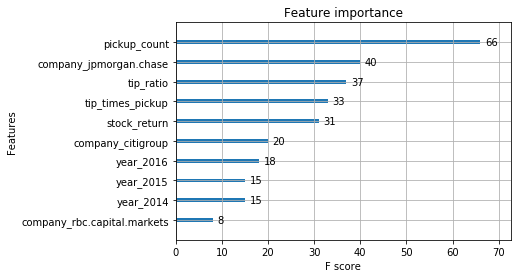

In [94]:
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb, max_num_features=10)
plt.show()

In [95]:
print("\nXGBoost Model Report")
print("MSE (Test) : {}".format(mean_squared_error(y_test, xgb.predict(X_test))))


XGBoost Model Report
MSE (Test) : 0.21298674788004537
